## Orquestador para recrear código Andrés

#### Parámetros importantes del código

In [1]:
# Valores primarios
nx = 40
ny = 40
kappa = 2
Lx = 1e-3
Ly = 1e-3
dt = 5e-5

# Valores derivados
h = Lx/nx
L = kappa * h
nFLuid = nx*ny
dx = Lx/nx
dy = Ly/ny

# Valor de apertura de pared
counter = 2300

In [1]:
import subprocess
from pathlib import Path

# --- Calcular ruta base del proyecto ---
PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "Config" else Path.cwd()

# --- Rutas principales ---
main_script = PROJECT_ROOT / "InitialConditions" / "main.py"

# Usamos los nuevos nombres de JSON generados por convertir_ics_a_json
boundary_path = PROJECT_ROOT / "Config" / "parameters" / "examples" / "Andres_boundary.json"
fluid_path = PROJECT_ROOT / "Config" / "parameters" / "examples" / "Andres_fluid_region.json"

# Ruta de salida y nombre del archivo resultante
output_dir = PROJECT_ROOT / "Output" / "init_cond"
output_name = "simAndres.txt"
output_log = "logSimAndres.json"
# --- Mostrar configuración para verificación ---
print("[INFO] Ejecutando main.py con los siguientes parámetros:")
print(f"  • Script principal: {main_script}")
print(f"  • Archivo de frontera: {boundary_path}")
print(f"  • Archivo de fluido:   {fluid_path}")
print(f"  • Carpeta de salida:   {output_dir}")
print(f"  • Nombre de salida:    {output_name}")
print(f"  • Nombre archivo resumen:    {output_log}")

# --- Ejecutar main.py ---
result = subprocess.run([
    "python", str(main_script),
    "export",
    "--boundary", str(boundary_path),
    "--fluid", str(fluid_path),
    "--output_dir", str(output_dir),
    "--output_file", output_name,
    "--output_logname", output_log
], capture_output=True, text=True)

# --- Mostrar resultados ---
if result.returncode == 0:
    print("\n[✓] Ejecución completada correctamente.")
    print(f"Archivo generado: {output_dir / output_name}")
else:
    print("\n[✗] Error durante la ejecución.")
    print("STDOUT:\n", result.stdout)
    print("STDERR:\n", result.stderr)


[INFO] Ejecutando main.py con los siguientes parámetros:
  • Script principal: /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/FloodSPH/InitialConditions/main.py
  • Archivo de frontera: /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/FloodSPH/Config/parameters/examples/Andres_boundary.json
  • Archivo de fluido:   /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/FloodSPH/Config/parameters/examples/Andres_fluid_region.json
  • Carpeta de salida:   /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/FloodSPH/Output/init_cond
  • Nombre de salida:    simAndres.txt
  • Nombre archivo resumen:    logSimAndres.json

[✓] Ejecución completada correctamente.
Archivo generado: /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/FloodSPH/Output/init_cond/simAndres.txt


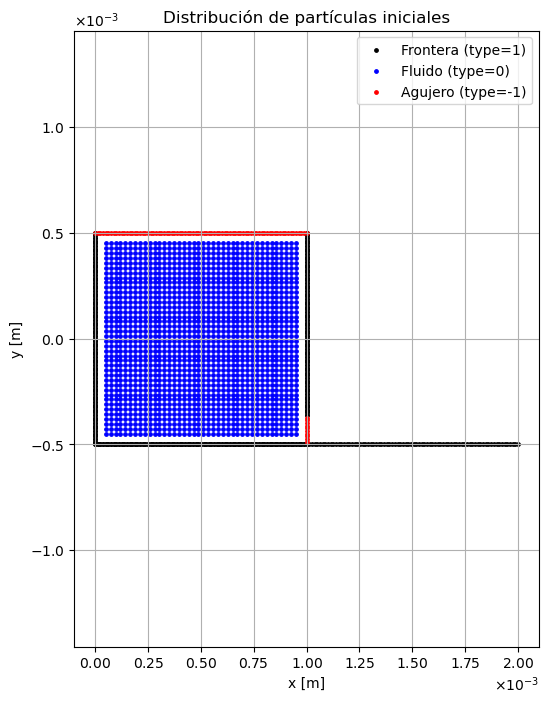

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.ticker import ScalarFormatter

# --- Rutas ---
PROJECT_ROOT = Path().resolve().parent        # Config → FloodSPH
output_file = PROJECT_ROOT / "Output" / "init_cond" / "simAndres.txt"

# --- Cargar datos ---
df = pd.read_csv(output_file, sep=" ")

# --- Separar por tipo ---
df_fluid = df[df["type"] == 0]
df_boundary = df[df["type"] == 1]
df_hole = df[df["type"] == -1]

# --- Graficar ---
plt.figure(figsize=(6, 8))
plt.scatter(df_boundary["posx"], df_boundary["posy"], s=6, c="black", label="Frontera (type=1)")
plt.scatter(df_fluid["posx"], df_fluid["posy"], s=6, c="blue", label="Fluido (type=0)")
plt.scatter(df_hole["posx"], df_hole["posy"], s=6, c="red", label="Agujero (type=-1)")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Distribución de partículas iniciales")
plt.legend()
plt.axis("equal")
plt.grid(True)

# --- Notación científica en los ejes ---
ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Mostrar figura
plt.show()


#### 1. Densidad Promedio

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# Ruta a la carpeta que contiene los archivos
PROJECT_ROOT = Path().resolve().parent        # Config → FloodSPH
OutputSim = PROJECT_ROOT / "Output" /"simulation"
archivos = sorted(glob.glob(os.path.join(OutputSim, "state_*.txt")))

promedios_rho = []
indices = []

for archivo in archivos:
    # Lee el archivo: separador = espacios, primera línea = encabezado
    df = pd.read_csv(archivo, sep=r"\s+", header=0)
    
    # Calcula el promedio de la columna rho
    promedio = df["rho"].mean()
    promedios_rho.append(promedio)
    
    # Extrae el índice (número del archivo)
    indice = int(os.path.basename(archivo).split("_")[1].split(".")[0])
    indices.append(indice)

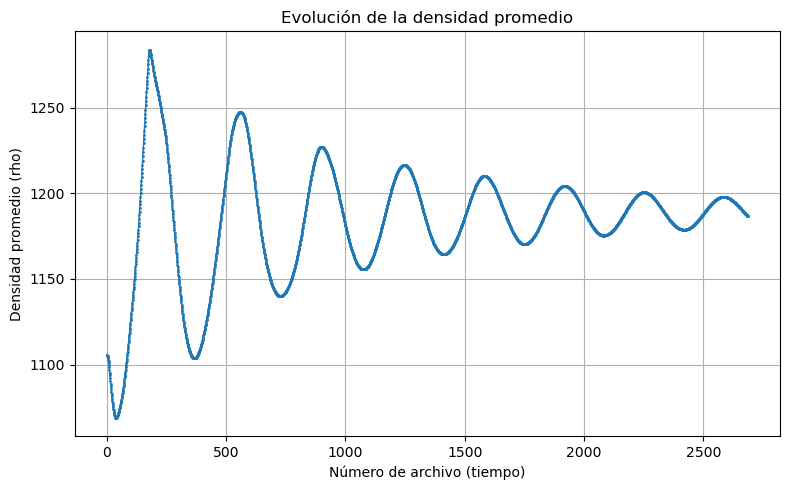

In [4]:
# Graficar la densidad promedio
plt.figure(figsize=(8,5))
plt.plot(indices, promedios_rho, marker='o', linewidth=1, markersize=1)
plt.xlabel("Número de archivo (tiempo)")
plt.ylabel("Densidad promedio (rho)")
plt.title("Evolución de la densidad promedio")
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
valor_medio = sum(promedios_rho) / len(promedios_rho)
print("Valor medio de densidad (equilibrio aproximado):", valor_medio)


Valor medio de densidad (equilibrio aproximado): 1183.4803548286666


In [6]:
n_final = int(0.2 * len(promedios_rho))  # último 20% de los datos
valor_medio_final = sum(promedios_rho[-n_final:]) / n_final
print("Valor medio en estado estacionario (último 20%):", valor_medio_final)


Valor medio en estado estacionario (último 20%): 1190.6886609956075


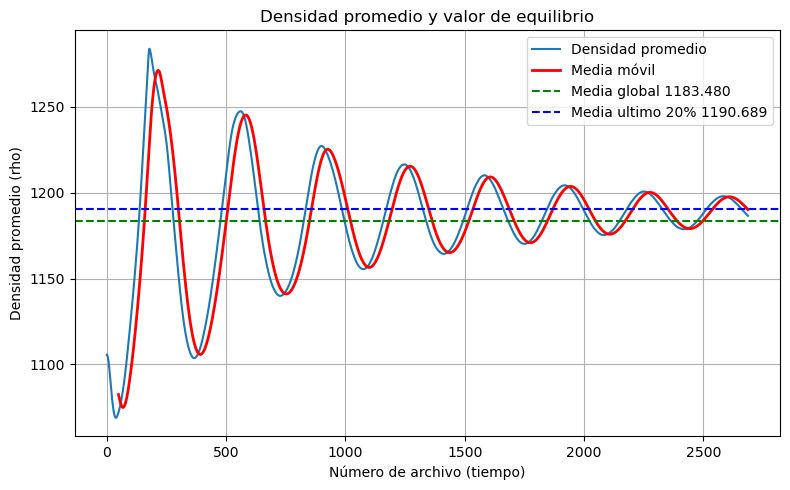

In [7]:
import numpy as np

ventana = 50  # número de puntos para suavizar
media_movil = np.convolve(promedios_rho, np.ones(ventana)/ventana, mode='valid')
media_global = np.mean(promedios_rho) 

plt.figure(figsize=(8,5))
plt.plot(indices, promedios_rho, label='Densidad promedio')
plt.plot(indices[ventana-1:], media_movil, 'r-', linewidth=2, label='Media móvil')
plt.axhline(media_global, color='g', linestyle='--', label=f'Media global {media_global:.3f}')
plt.axhline(valor_medio_final, color='b', linestyle='--', label=f'Media ultimo 20% {valor_medio_final:.3f}')
plt.xlabel("Número de archivo (tiempo)")
plt.ylabel("Densidad promedio (rho)")
plt.title("Densidad promedio y valor de equilibrio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 1.1 Barrido sobre la velocidad del sonido C, para B = 1:

In [13]:
import json
from pathlib import Path
from datetime import datetime
import numpy as np

# ========================= CONFIGURACIÓN ========================= #
PROJECT_ROOT = Path().resolve().parent    # ruta raíz del proyecto, por ejemplo: /home/usuario/FloodSPH/base

# Archivo JSON base (parámetros originales)
base_json_path = PROJECT_ROOT / "Config" / "parameters" / "simulation" / "AndresSimParams.json"

# Carpeta de salida principal
OutputSim = PROJECT_ROOT / "Output"

# Carpeta donde se guardarán los experimentos con c modificado
experiments_root = OutputSim / "experiments_c"
experiments_root.mkdir(parents=True, exist_ok=True)

# Barrido de valores de c en escala logarítmica (de 1e-3 a 1e-1)
c_values = np.logspace(np.log10(0.001), np.log10(10), 20)

# Parámetros fijos y de control
B_fixed = 1.0
steps = 500
# ================================================================ #

# Leer archivo base
with open(base_json_path, "r") as f:
    base_params = json.load(f)

# Crear experimento por cada valor de c
for c in c_values:
    # Crear carpeta única para esta simulación
    run_name = f"experiment_c{c:.6f}"
    run_dir = experiments_root / run_name
    run_dir.mkdir(parents=True, exist_ok=True)

    # Copia profunda del JSON base
    params = json.loads(json.dumps(base_params))

    # Actualizar parámetros físicos
    params["physics"]["eos_params"]["monaghan"]["c"] = float(c)
    params["physics"]["eos_params"]["monaghan"]["B"] = float(B_fixed)

    # Actualizar número de pasos
    params["integrator"]["n_steps"] = steps

    # Redefinir carpeta de salida de la simulación
    sim_output_dir = run_dir / "Output"
    sim_output_dir.mkdir(parents=True, exist_ok=True)
    params["io"]["output_dir_simulation"] = str(sim_output_dir)

    # Guardar el archivo modificado de parámetros
    param_file = run_dir / "params.json"
    with open(param_file, "w") as f:
        json.dump(params, f, indent=2)

    print(f"✅ Generado: {param_file.relative_to(PROJECT_ROOT)}")

✅ Generado: Output/experiments_c/experiment_c0.001000/params.json
✅ Generado: Output/experiments_c/experiment_c0.001624/params.json
✅ Generado: Output/experiments_c/experiment_c0.002637/params.json
✅ Generado: Output/experiments_c/experiment_c0.004281/params.json
✅ Generado: Output/experiments_c/experiment_c0.006952/params.json
✅ Generado: Output/experiments_c/experiment_c0.011288/params.json
✅ Generado: Output/experiments_c/experiment_c0.018330/params.json
✅ Generado: Output/experiments_c/experiment_c0.029764/params.json
✅ Generado: Output/experiments_c/experiment_c0.048329/params.json
✅ Generado: Output/experiments_c/experiment_c0.078476/params.json
✅ Generado: Output/experiments_c/experiment_c0.127427/params.json
✅ Generado: Output/experiments_c/experiment_c0.206914/params.json
✅ Generado: Output/experiments_c/experiment_c0.335982/params.json
✅ Generado: Output/experiments_c/experiment_c0.545559/params.json
✅ Generado: Output/experiments_c/experiment_c0.885867/params.json
✅ Generado

In [14]:
print(c_values)

[1.00000000e-03 1.62377674e-03 2.63665090e-03 4.28133240e-03
 6.95192796e-03 1.12883789e-02 1.83298071e-02 2.97635144e-02
 4.83293024e-02 7.84759970e-02 1.27427499e-01 2.06913808e-01
 3.35981829e-01 5.45559478e-01 8.85866790e-01 1.43844989e+00
 2.33572147e+00 3.79269019e+00 6.15848211e+00 1.00000000e+01]


In [15]:
import subprocess
from pathlib import Path
import time

# ========================= CONFIGURACIÓN ========================= #
PROJECT_ROOT = Path().resolve().parent      # raíz del proyecto, por ejemplo base/
sim_executable = PROJECT_ROOT / "simulacion"  # ejecutable, ej: ./simulacion
experiments_root = PROJECT_ROOT / "Output" / "experiments_c"

timeout_simulation = 300   # límite de tiempo por simulación (segundos)
# ================================================================ #

# Buscar todos los archivos params.json en subcarpetas
param_files = sorted(experiments_root.glob("experiment_c*/params.json"))

print(f"\n🔍 Se encontraron {len(param_files)} archivos de simulación.\n")

for param_file in param_files:
    run_dir = param_file.parent
    run_name = run_dir.name
    print(f"🚀 Ejecutando {run_name} ...")

    stdout_path = run_dir / "stdout.txt"
    stderr_path = run_dir / "stderr.txt"

    cmd = [str(sim_executable), str(param_file)]

    start_time = time.time()
    try:
        with open(stdout_path, "wb") as out, open(stderr_path, "wb") as err:
            proc = subprocess.run(
                cmd,
                stdout=out,
                stderr=err,
                timeout=timeout_simulation,
                cwd=PROJECT_ROOT  # ejecuta desde la raíz del proyecto
            )
        elapsed = time.time() - start_time

        if proc.returncode == 0:
            print(f"  ✅ Finalizado correctamente ({elapsed:.1f} s)")
        else:
            print(f"  ⚠️ Finalizado con código {proc.returncode} ({elapsed:.1f} s)")

    except subprocess.TimeoutExpired:
        print(f"  ❌ TIMEOUT tras {timeout_simulation}s — simulación detenida")
        # opcionalmente guardar estado
        with open(stderr_path, "a") as err:
            err.write(f"\n[ERROR] Timeout tras {timeout_simulation}s\n")



🔍 Se encontraron 20 archivos de simulación.

🚀 Ejecutando experiment_c0.001000 ...
  ✅ Finalizado correctamente (74.2 s)
🚀 Ejecutando experiment_c0.001624 ...
  ✅ Finalizado correctamente (77.7 s)
🚀 Ejecutando experiment_c0.002637 ...
  ✅ Finalizado correctamente (77.8 s)
🚀 Ejecutando experiment_c0.004281 ...
  ✅ Finalizado correctamente (77.0 s)
🚀 Ejecutando experiment_c0.006952 ...
  ✅ Finalizado correctamente (77.2 s)
🚀 Ejecutando experiment_c0.011288 ...
  ✅ Finalizado correctamente (80.3 s)
🚀 Ejecutando experiment_c0.018330 ...
  ✅ Finalizado correctamente (90.7 s)
🚀 Ejecutando experiment_c0.029764 ...
  ✅ Finalizado correctamente (86.7 s)
🚀 Ejecutando experiment_c0.048329 ...
  ✅ Finalizado correctamente (81.2 s)
🚀 Ejecutando experiment_c0.078476 ...
  ✅ Finalizado correctamente (82.3 s)
🚀 Ejecutando experiment_c0.127427 ...
  ✅ Finalizado correctamente (77.9 s)
🚀 Ejecutando experiment_c0.206914 ...
  ✅ Finalizado correctamente (80.3 s)
🚀 Ejecutando experiment_c0.335982 ...
  ✅ 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
import glob

# =================== CONFIGURACIÓN =================== #
PROJECT_ROOT = Path().resolve().parent
experiments_root = PROJECT_ROOT / "Output" / "experiments_c"
results_csv = experiments_root / "results_density_vs_c.csv"
# ===================================================== #

rows = []

# Buscar todos los experimentos
param_files = sorted(experiments_root.glob("experiment_c*/params.json"))

for param_file in param_files:
    run_dir = param_file.parent
    with open(param_file, "r") as f:
        params = json.load(f)

    # Valor de c (desde el JSON)
    c_value = params["physics"]["eos_params"]["monaghan"]["c"]

    # Buscar archivos de simulación
    sim_dir = Path(params["io"]["output_dir_simulation"])
    state_files = sorted(glob.glob(str(sim_dir / "state_*.txt")))

    if len(state_files) == 0:
        print(f"⚠️ No se encontraron archivos de estado para c={c_value:.6f}")
        continue

    rho_means = []
    for sf in state_files:
        try:
            df = pd.read_csv(sf, sep=r"\s+", header=0)
            if "rho" not in df.columns:
                continue
            rho_means.append(df["rho"].mean())
        except Exception as e:
            print(f"Error leyendo {sf}: {e}")

    if len(rho_means) == 0:
        print(f"⚠️ No se pudo calcular densidad para c={c_value:.6f}")
        continue

    rho_global_mean = np.mean(rho_means)
    rows.append({"c": round(c_value,6), "rho_mean": rho_global_mean})

# Crear DataFrame con resultados
df_results = pd.DataFrame(rows).sort_values("c")
df_results.to_csv(results_csv, index=False)
print(f"\n✅ Resultados guardados en: {results_csv}")


✅ Resultados guardados en: /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/FloodSPH/Output/experiments_c/results_density_vs_c.csv


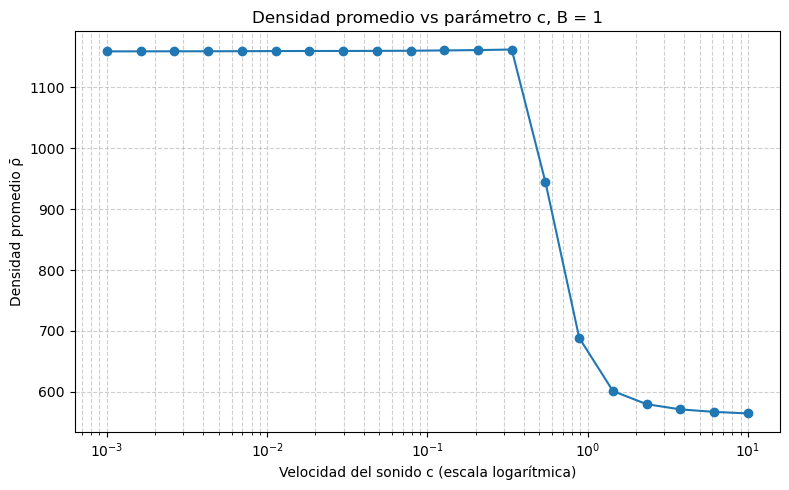

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ========== CONFIGURACIÓN ==========
PROJECT_ROOT = Path().resolve().parent
results_csv = PROJECT_ROOT / "Output" / "experiments_c" / "results_density_vs_c.csv"
# ===================================

# Leer el CSV
df = pd.read_csv(results_csv)

# Ordenar por valor de c (por si no lo está)
df = df.sort_values("c")

# =================== GRÁFICO =================== #
plt.figure(figsize=(8, 5))
plt.plot(df["c"], df["rho_mean"], marker="o", linestyle="-", linewidth=1.5)
plt.xscale("log")  # escala logarítmica en eje x
plt.xlabel("Velocidad del sonido c (escala logarítmica)")
plt.ylabel("Densidad promedio ρ̄")
plt.title("Densidad promedio vs parámetro c, B = 1")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Se ejecutan simulaciones de mas paso en el intervalo en el que la simulación parece estable

In [23]:
import json
from pathlib import Path
from datetime import datetime
import numpy as np

# ========================= CONFIGURACIÓN ========================= #
PROJECT_ROOT = Path().resolve().parent    # ruta raíz del proyecto, por ejemplo: /home/usuario/FloodSPH/base

# Archivo JSON base (parámetros originales)
base_json_path = PROJECT_ROOT / "Config" / "parameters" / "simulation" / "AndresSimParams.json"

# Carpeta de salida principal
OutputSim = PROJECT_ROOT / "Output"

# Carpeta donde se guardarán los experimentos con c modificado
experiments_root = OutputSim / "exp_c_estable"
experiments_root.mkdir(parents=True, exist_ok=True)

# Barrido de valores de c en escala logarítmica (de 1e-3 a 1e-1)
c_values = np.logspace(np.log10(1e-5), np.log10(0.34), 10)

# Parámetros fijos y de control
B_fixed = 1.0
steps = 3000
# ================================================================ #

# Leer archivo base
with open(base_json_path, "r") as f:
    base_params = json.load(f)

# Crear experimento por cada valor de c
for c in c_values:
    # Crear carpeta única para esta simulación
    run_name = f"experiment_c{c:.6f}"
    run_dir = experiments_root / run_name
    run_dir.mkdir(parents=True, exist_ok=True)

    # Copia profunda del JSON base
    params = json.loads(json.dumps(base_params))

    # Actualizar parámetros físicos
    params["physics"]["eos_params"]["monaghan"]["c"] = float(c)
    params["physics"]["eos_params"]["monaghan"]["B"] = float(B_fixed)

    # Actualizar número de pasos
    params["integrator"]["n_steps"] = steps

    # Redefinir carpeta de salida de la simulación
    sim_output_dir = run_dir / "Output"
    sim_output_dir.mkdir(parents=True, exist_ok=True)
    params["io"]["output_dir_simulation"] = str(sim_output_dir)

    # Guardar el archivo modificado de parámetros
    param_file = run_dir / "params.json"
    with open(param_file, "w") as f:
        json.dump(params, f, indent=2)

    print(f"✅ Generado: {param_file.relative_to(PROJECT_ROOT)}")

✅ Generado: Output/exp_c_estable/experiment_c0.000010/params.json
✅ Generado: Output/exp_c_estable/experiment_c0.000032/params.json
✅ Generado: Output/exp_c_estable/experiment_c0.000102/params.json
✅ Generado: Output/exp_c_estable/experiment_c0.000324/params.json
✅ Generado: Output/exp_c_estable/experiment_c0.001033/params.json
✅ Generado: Output/exp_c_estable/experiment_c0.003292/params.json
✅ Generado: Output/exp_c_estable/experiment_c0.010495/params.json
✅ Generado: Output/exp_c_estable/experiment_c0.033457/params.json
✅ Generado: Output/exp_c_estable/experiment_c0.106655/params.json
✅ Generado: Output/exp_c_estable/experiment_c0.340000/params.json


In [24]:
import subprocess
from pathlib import Path
import time

# ========================= CONFIGURACIÓN ========================= #
PROJECT_ROOT = Path().resolve().parent      # raíz del proyecto, por ejemplo base/
sim_executable = PROJECT_ROOT / "simulacion"  # ejecutable, ej: ./simulacion
experiments_root = PROJECT_ROOT / "Output" / "exp_c_estable"

timeout_simulation = 3000   # límite de tiempo por simulación (segundos)
# ================================================================ #

# Buscar todos los archivos params.json en subcarpetas
param_files = sorted(experiments_root.glob("experiment_c*/params.json"))

print(f"\n🔍 Se encontraron {len(param_files)} archivos de simulación.\n")

for param_file in param_files:
    run_dir = param_file.parent
    run_name = run_dir.name
    print(f"🚀 Ejecutando {run_name} ...")

    stdout_path = run_dir / "stdout.txt"
    stderr_path = run_dir / "stderr.txt"

    cmd = [str(sim_executable), str(param_file)]

    start_time = time.time()
    try:
        with open(stdout_path, "wb") as out, open(stderr_path, "wb") as err:
            proc = subprocess.run(
                cmd,
                stdout=out,
                stderr=err,
                timeout=timeout_simulation,
                cwd=PROJECT_ROOT  # ejecuta desde la raíz del proyecto
            )
        elapsed = time.time() - start_time

        if proc.returncode == 0:
            print(f"  ✅ Finalizado correctamente ({elapsed:.1f} s)")
        else:
            print(f"  ⚠️ Finalizado con código {proc.returncode} ({elapsed:.1f} s)")

    except subprocess.TimeoutExpired:
        print(f"  ❌ TIMEOUT tras {timeout_simulation}s — simulación detenida")
        # opcionalmente guardar estado
        with open(stderr_path, "a") as err:
            err.write(f"\n[ERROR] Timeout tras {timeout_simulation}s\n")



🔍 Se encontraron 10 archivos de simulación.

🚀 Ejecutando experiment_c0.000010 ...
  ✅ Finalizado correctamente (494.1 s)
🚀 Ejecutando experiment_c0.000032 ...
  ✅ Finalizado correctamente (489.8 s)
🚀 Ejecutando experiment_c0.000102 ...
  ✅ Finalizado correctamente (466.3 s)
🚀 Ejecutando experiment_c0.000324 ...
  ✅ Finalizado correctamente (481.8 s)
🚀 Ejecutando experiment_c0.001033 ...
  ✅ Finalizado correctamente (492.7 s)
🚀 Ejecutando experiment_c0.003292 ...
  ✅ Finalizado correctamente (486.7 s)
🚀 Ejecutando experiment_c0.010495 ...
  ✅ Finalizado correctamente (500.1 s)
🚀 Ejecutando experiment_c0.033457 ...
  ✅ Finalizado correctamente (504.8 s)
🚀 Ejecutando experiment_c0.106655 ...
  ✅ Finalizado correctamente (479.6 s)
🚀 Ejecutando experiment_c0.340000 ...
  ✅ Finalizado correctamente (527.9 s)



✅ Resultados guardados en: /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/FloodSPH/Output/exp_c_estable/results_density_vs_c.csv


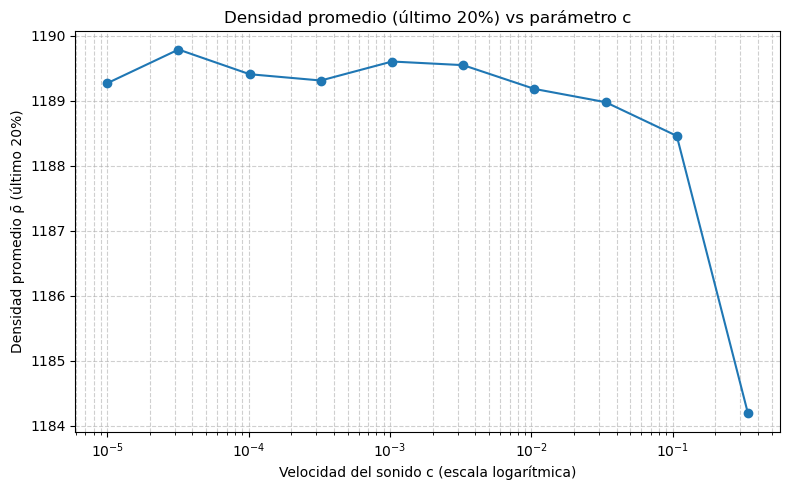

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
import glob

# =================== CONFIGURACIÓN =================== #
PROJECT_ROOT = Path().resolve().parent
experiments_root = PROJECT_ROOT / "Output" / "exp_c_estable"
results_csv = experiments_root / "results_density_vs_c.csv"
fraction_final = 0.2   # último 20 % de los archivos
# ===================================================== #

rows = []

# Buscar todos los experimentos (cada carpeta tiene un params.json)
param_files = sorted(experiments_root.glob("experiment_c*/params.json"))

for param_file in param_files:
    run_dir = param_file.parent
    with open(param_file, "r") as f:
        params = json.load(f)

    # Valor de c desde el JSON
    c_value = params["physics"]["eos_params"]["monaghan"]["c"]

    # Buscar los archivos de simulación
    sim_dir = Path(params["io"]["output_dir_simulation"])
    state_files = sorted(glob.glob(str(sim_dir / "state_*.txt")))

    if len(state_files) == 0:
        print(f"⚠️ No se encontraron archivos de estado para c={c_value:.10f}")
        continue

    # Tomar solo el último 20 % de los archivos
    n_total = len(state_files)
    n_last = max(1, int(n_total * fraction_final))
    state_files = state_files[-n_last:]

    rho_means = []
    for sf in state_files:
        try:
            df = pd.read_csv(sf, sep=r"\s+", header=0)
            if "rho" not in df.columns:
                continue
            rho_means.append(df["rho"].mean())
        except Exception as e:
            print(f"Error leyendo {sf}: {e}")

    if len(rho_means) == 0:
        print(f"⚠️ No se pudo calcular densidad para c={c_value:.10f}")
        continue

    rho_means = np.array(rho_means)
    rho_mean_last = np.mean(rho_means)
    rho_min_last = np.min(rho_means)
    rho_max_last = np.max(rho_means)

    rows.append({
        "c": round(c_value, 10),
        "rho_mean_last20": rho_mean_last,
        "rho_min_last20": rho_min_last,
        "rho_max_last20": rho_max_last,
        "n_used": len(rho_means)
    })

# Crear DataFrame con resultados
df_results = pd.DataFrame(rows).sort_values("c")
df_results.to_csv(results_csv, index=False)
print(f"\n✅ Resultados guardados en: {results_csv}")

# =================== GRÁFICO =================== #
plt.figure(figsize=(8, 5))
plt.plot(df_results["c"], df_results["rho_mean_last20"], marker="o", linestyle="-", linewidth=1.5)
plt.xscale("log")
plt.xlabel("Velocidad del sonido c (escala logarítmica)")
plt.ylabel("Densidad promedio ρ̄ (último 20%)")
plt.title("Densidad promedio (último 20%) vs parámetro c")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#### Tomar densidad de punto intermedio c = 1e-3

- Ejecutar simulación hasta 6000, variar el parámetro de B por arriba y por abajo, haciendo el mismo algoritmo de cambio de pasos usado anteriormente.

- Con la velocidad del sonido, hacer una variación sobre la densidad inicial por arriba y por abajo.

#### Barrido sobre el parámetro de presión B, c = 0.001

In [8]:
import json
from pathlib import Path
from datetime import datetime
import numpy as np

# ========================= CONFIGURACIÓN ========================= #
PROJECT_ROOT = Path().resolve().parent    # ruta raíz del proyecto, por ejemplo: /home/usuario/FloodSPH/base

# Archivo JSON base (parámetros originales)
base_json_path = PROJECT_ROOT / "Config" / "parameters" / "simulation" / "AndresSimParams.json"

# Carpeta de salida principal
OutputSim = PROJECT_ROOT / "Output"

# Carpeta donde se guardarán los experimentos con c modificado
experiments_root = OutputSim / "experiments_B"
experiments_root.mkdir(parents=True, exist_ok=True)

# Barrido de valores de B en escala logarítmica (de 0.01 a 100)
B_values = np.logspace(np.log10(0.01), np.log10(100), 20)

# Parámetros fijos y de control
c_fixed = 1e-3
steps = 500
# ================================================================ #

# Leer archivo base
with open(base_json_path, "r") as f:
    base_params = json.load(f)

# Crear experimento por cada valor de B
for B in B_values:
    # Crear carpeta única para esta simulación
    run_name = f"experiment_B{B:.6f}"
    run_dir = experiments_root / run_name
    run_dir.mkdir(parents=True, exist_ok=True)

    # Copia profunda del JSON base
    params = json.loads(json.dumps(base_params))

    # Actualizar parámetros físicos
    params["physics"]["eos_params"]["monaghan"]["c"] = float(c_fixed)
    params["physics"]["eos_params"]["monaghan"]["B"] = float(B)

    # Actualizar número de pasos
    params["integrator"]["n_steps"] = steps

    # Redefinir carpeta de salida de la simulación
    sim_output_dir = run_dir / "Output"
    sim_output_dir.mkdir(parents=True, exist_ok=True)
    params["io"]["output_dir_simulation"] = str(sim_output_dir)

    # Guardar el archivo modificado de parámetros
    param_file = run_dir / "params.json"
    with open(param_file, "w") as f:
        json.dump(params, f, indent=2)

    print(f"✅ Generado: {param_file.relative_to(PROJECT_ROOT)}")

✅ Generado: Output/experiments_B/experiment_B0.010000/params.json
✅ Generado: Output/experiments_B/experiment_B0.016238/params.json
✅ Generado: Output/experiments_B/experiment_B0.026367/params.json
✅ Generado: Output/experiments_B/experiment_B0.042813/params.json
✅ Generado: Output/experiments_B/experiment_B0.069519/params.json
✅ Generado: Output/experiments_B/experiment_B0.112884/params.json
✅ Generado: Output/experiments_B/experiment_B0.183298/params.json
✅ Generado: Output/experiments_B/experiment_B0.297635/params.json
✅ Generado: Output/experiments_B/experiment_B0.483293/params.json
✅ Generado: Output/experiments_B/experiment_B0.784760/params.json
✅ Generado: Output/experiments_B/experiment_B1.274275/params.json
✅ Generado: Output/experiments_B/experiment_B2.069138/params.json
✅ Generado: Output/experiments_B/experiment_B3.359818/params.json
✅ Generado: Output/experiments_B/experiment_B5.455595/params.json
✅ Generado: Output/experiments_B/experiment_B8.858668/params.json
✅ Generado

In [9]:
import subprocess
from pathlib import Path
import time

# ========================= CONFIGURACIÓN ========================= #
PROJECT_ROOT = Path().resolve().parent      # raíz del proyecto, por ejemplo base/
sim_executable = PROJECT_ROOT / "simulacion"  # ejecutable, ej: ./simulacion
experiments_root = PROJECT_ROOT / "Output" / "experiments_B"

timeout_simulation = 300   # límite de tiempo por simulación (segundos)
# ================================================================ #

# Buscar todos los archivos params.json en subcarpetas
param_files = sorted(experiments_root.glob("experiment_B*/params.json"))

print(f"\n🔍 Se encontraron {len(param_files)} archivos de simulación.\n")

for param_file in param_files:
    run_dir = param_file.parent
    run_name = run_dir.name
    print(f"🚀 Ejecutando {run_name} ...")

    stdout_path = run_dir / "stdout.txt"
    stderr_path = run_dir / "stderr.txt"

    cmd = [str(sim_executable), str(param_file)]

    start_time = time.time()
    try:
        with open(stdout_path, "wb") as out, open(stderr_path, "wb") as err:
            proc = subprocess.run(
                cmd,
                stdout=out,
                stderr=err,
                timeout=timeout_simulation,
                cwd=PROJECT_ROOT  # ejecuta desde la raíz del proyecto
            )
        elapsed = time.time() - start_time

        if proc.returncode == 0:
            print(f"  ✅ Finalizado correctamente ({elapsed:.1f} s)")
        else:
            print(f"  ⚠️ Finalizado con código {proc.returncode} ({elapsed:.1f} s)")

    except subprocess.TimeoutExpired:
        print(f"  ❌ TIMEOUT tras {timeout_simulation}s — simulación detenida")
        # opcionalmente guardar estado
        with open(stderr_path, "a") as err:
            err.write(f"\n[ERROR] Timeout tras {timeout_simulation}s\n")


🔍 Se encontraron 20 archivos de simulación.

🚀 Ejecutando experiment_B0.010000 ...
  ✅ Finalizado correctamente (84.2 s)
🚀 Ejecutando experiment_B0.016238 ...
  ✅ Finalizado correctamente (90.6 s)
🚀 Ejecutando experiment_B0.026367 ...
  ✅ Finalizado correctamente (80.1 s)
🚀 Ejecutando experiment_B0.042813 ...
  ✅ Finalizado correctamente (80.6 s)
🚀 Ejecutando experiment_B0.069519 ...
  ✅ Finalizado correctamente (79.2 s)
🚀 Ejecutando experiment_B0.112884 ...
  ✅ Finalizado correctamente (80.4 s)
🚀 Ejecutando experiment_B0.183298 ...
  ✅ Finalizado correctamente (83.3 s)
🚀 Ejecutando experiment_B0.297635 ...
  ✅ Finalizado correctamente (75.9 s)
🚀 Ejecutando experiment_B0.483293 ...
  ✅ Finalizado correctamente (80.5 s)
🚀 Ejecutando experiment_B0.784760 ...
  ✅ Finalizado correctamente (77.9 s)
🚀 Ejecutando experiment_B1.274275 ...
  ✅ Finalizado correctamente (75.2 s)
🚀 Ejecutando experiment_B100.000000 ...
  ✅ Finalizado correctamente (74.2 s)
🚀 Ejecutando experiment_B14.384499 ...
 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
import glob

# =================== CONFIGURACIÓN =================== #
PROJECT_ROOT = Path().resolve().parent
experiments_root = PROJECT_ROOT / "Output" / "experiments_B"
results_csv = experiments_root / "results_density_vs_B.csv"
# ===================================================== #

rows = []

# Buscar todos los experimentos
param_files = sorted(experiments_root.glob("experiment_B*/params.json"))

for param_file in param_files:
    run_dir = param_file.parent
    with open(param_file, "r") as f:
        params = json.load(f)

    # Valor de c (desde el JSON)
    B_value = params["physics"]["eos_params"]["monaghan"]["B"]

    # Buscar archivos de simulación
    sim_dir = Path(params["io"]["output_dir_simulation"])
    state_files = sorted(glob.glob(str(sim_dir / "state_*.txt")))

    if len(state_files) == 0:
        print(f"⚠️ No se encontraron archivos de estado para B={B_value:.6f}")
        continue

    rho_means = []
    for sf in state_files:
        try:
            df = pd.read_csv(sf, sep=r"\s+", header=0)
            if "rho" not in df.columns:
                continue
            rho_means.append(df["rho"].mean())
        except Exception as e:
            print(f"Error leyendo {sf}: {e}")

    if len(rho_means) == 0:
        print(f"⚠️ No se pudo calcular densidad para B={B_value:.6f}")
        continue

    rho_global_mean = np.mean(rho_means)
    rows.append({"B": round(B_value,6), "rho_mean": rho_global_mean})

# Crear DataFrame con resultados
df_results = pd.DataFrame(rows).sort_values("B")
df_results.to_csv(results_csv, index=False)
print(f"\n✅ Resultados guardados en: {results_csv}")


✅ Resultados guardados en: /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/FloodSPH/Output/experiments_B/results_density_vs_B.csv


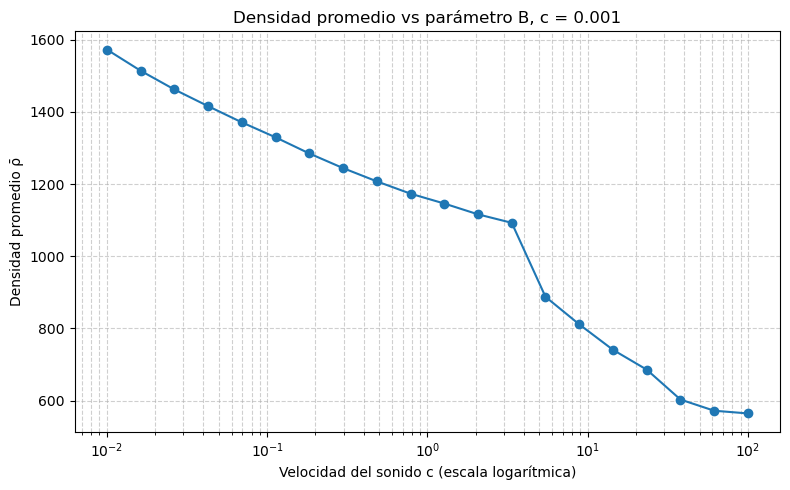

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ========== CONFIGURACIÓN ==========
PROJECT_ROOT = Path().resolve().parent
results_csv = PROJECT_ROOT / "Output" / "experiments_B" / "results_density_vs_B.csv"
# ===================================

# Leer el CSV
df = pd.read_csv(results_csv)

# Ordenar por valor de c (por si no lo está)
df = df.sort_values("B")

# =================== GRÁFICO =================== #
plt.figure(figsize=(8, 5))
plt.plot(df["B"], df["rho_mean"], marker="o", linestyle="-", linewidth=1.5)
plt.xscale("log")  # escala logarítmica en eje x
plt.xlabel("Parámetro B (escala logarítmica)")
plt.ylabel("Densidad promedio ρ̄")
plt.title("Densidad promedio vs parámetro B, c = 0.001")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [2]:
valorSuperior1000 = df["rho_mean"][12]
valorInferior1000 = df["rho_mean"][13]
Bsup = df["B"][12]
Binf = df["B"][13]
print(f"Límite superior región central de densidad: {valorSuperior1000:.3f} valor de B = {Bsup}")
print(f"Límite inferior región central de densidad: {valorInferior1000:.3f} valor de B = {Binf}")

Límite superior región central de densidad: 1092.633 valor de B = 3.359818
Límite inferior región central de densidad: 887.709 valor de B = 5.455595


partiendo de c en el intermedio realizarlo siguiente: 
1. variar la densidad por arriba y por baajo, densidad inicial, con pocos pasos, y mirar a que valor estiliza.
2. Elegir la más cercano a la densidad del agua, y tirar una simulacion larga de 6000 pasos, abrir el tanque y dejar caer el agua.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ========== CONFIGURACIÓN ==========
PROJECT_ROOT = Path().resolve().parent
results_csv = PROJECT_ROOT / "Output" / "experiments_B" / "results_density_vs_B.csv"
# ===================================

# Leer el CSV
df = pd.read_csv(results_csv)

df = df.sort_values("B")
vals_B = df["B"].to_list()
vals_rhoM = df["rho_mean"].to_list()

for b, rhoM in zip(vals_B, vals_rhoM): 
    print(f"Variable B = {b} con rho_mean = {rhoM}")

Variable B = 0.01 con rho_mean = 1572.731916920117
Variable B = 0.016238 con rho_mean = 1514.062261362562
Variable B = 0.026367 con rho_mean = 1462.1410714171843
Variable B = 0.042813 con rho_mean = 1415.8943047907292
Variable B = 0.069519 con rho_mean = 1371.0493723533405
Variable B = 0.112884 con rho_mean = 1329.5103988534015
Variable B = 0.183298 con rho_mean = 1284.7977076230286
Variable B = 0.297635 con rho_mean = 1244.271058109313
Variable B = 0.483293 con rho_mean = 1207.547171816081
Variable B = 0.78476 con rho_mean = 1173.3878282003045
Variable B = 1.274275 con rho_mean = 1146.0994047676484
Variable B = 2.069138 con rho_mean = 1116.160654256831
Variable B = 3.359818 con rho_mean = 1092.632801551315
Variable B = 5.455595 con rho_mean = 887.7092732512992
Variable B = 8.858668 con rho_mean = 811.4009947532335
Variable B = 14.384499 con rho_mean = 740.8313408979542
Variable B = 23.357215 con rho_mean = 685.9354833640333
Variable B = 37.926902 con rho_mean = 603.0658550396033
Varia

### Generamos simulaciones con 4 valores hasta los 7.000 pasos para ver el tiempo de estabilización:

### Los valores de B son: 0.48, 1.27, 3.35, 4.0.

In [9]:
import json
from pathlib import Path
from datetime import datetime
import numpy as np

# ========================= CONFIGURACIÓN ========================= #
PROJECT_ROOT = Path().resolve().parent    # ruta raíz del proyecto, por ejemplo: /home/usuario/FloodSPH/base

# Archivo JSON base (parámetros originales)
base_json_path = PROJECT_ROOT / "Config" / "parameters" / "simulation" / "AndresSimParams.json"

# Carpeta de salida principal
OutputSim = PROJECT_ROOT / "Output"

# Carpeta donde se guardarán los experimentos con c modificado
experiments_root = OutputSim / "exp_B_4x7k"
experiments_root.mkdir(parents=True, exist_ok=True)

# Barrido de valores de B en escala logarítmica (de 0.01 a 100)
B_values = np.array([0.48, 1.27, 3.35, 4.0])

# Parámetros fijos y de control
c_fixed = 1e-3
steps = 7000
# ================================================================ #

# Leer archivo base
with open(base_json_path, "r") as f:
    base_params = json.load(f)

# Crear experimento por cada valor de B
for B in B_values:
    # Crear carpeta única para esta simulación
    run_name = f"experiment_B{B:.6f}"
    run_dir = experiments_root / run_name
    run_dir.mkdir(parents=True, exist_ok=True)

    # Copia profunda del JSON base
    params = json.loads(json.dumps(base_params))

    # Actualizar parámetros físicos
    params["physics"]["eos_params"]["monaghan"]["c"] = float(c_fixed)
    params["physics"]["eos_params"]["monaghan"]["B"] = float(B)

    # Actualizar número de pasos
    params["integrator"]["n_steps"] = steps

    # Redefinir carpeta de salida de la simulación
    sim_output_dir = run_dir / "Output"
    sim_output_dir.mkdir(parents=True, exist_ok=True)
    params["io"]["output_dir_simulation"] = str(sim_output_dir)

    # Guardar el archivo modificado de parámetros
    param_file = run_dir / "params.json"
    with open(param_file, "w") as f:
        json.dump(params, f, indent=2)

    print(f"✅ Generado: {param_file.relative_to(PROJECT_ROOT)}")

✅ Generado: Output/exp_B_4x7k/experiment_B0.480000/params.json
✅ Generado: Output/exp_B_4x7k/experiment_B1.270000/params.json
✅ Generado: Output/exp_B_4x7k/experiment_B3.350000/params.json
✅ Generado: Output/exp_B_4x7k/experiment_B4.000000/params.json


In [11]:
import subprocess
from pathlib import Path
import time
import threading

# ========================= CONFIGURACIÓN ========================= #
PROJECT_ROOT = Path().resolve().parent      # raíz del proyecto
sim_executable = PROJECT_ROOT / "simulacion"
experiments_root = PROJECT_ROOT / "Output" / "exp_B_4x7k"

timeout_simulation = 6300   # límite de tiempo en segundos
# ================================================================ #

# Buscar todos los archivos params.json
param_files = sorted(experiments_root.glob("experiment_B*/params.json"))

print(f"\n🔍 Se encontraron {len(param_files)} archivos de simulación.\n")

def run_with_timeout(proc, timeout):
    """Maneja el timeout de Popen."""
    try:
        proc.wait(timeout=timeout)
    except subprocess.TimeoutExpired:
        proc.kill()
        raise

for param_file in param_files:
    run_dir = param_file.parent
    run_name = run_dir.name
    print(f"\n🚀 Ejecutando {run_name} ...\n")

    stdout_path = run_dir / "stdout.txt"
    stderr_path = run_dir / "stderr.txt"
    err_log = open(stderr_path, "w")

    cmd = [str(sim_executable), str(param_file)]

    start_time = time.time()

    try:
        # Iniciar proceso
        proc = subprocess.Popen(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            cwd=PROJECT_ROOT
        )

        # ---- Lectura de stdout EN TIEMPO REAL ----
        with open(stdout_path, "w") as out_file:
            for line in iter(proc.stdout.readline, ""):
                print(line, end="")    # mostrar en Jupyter
                out_file.write(line)   # guardar en archivo

        # ---- Lectura final de stderr ----
        stderr_output = proc.stderr.read()
        if stderr_output:
            print("\n[STDERR]\n" + stderr_output)
            err_log.write(stderr_output)

        run_with_timeout(proc, timeout_simulation)
        elapsed = time.time() - start_time

        if proc.returncode == 0:
            print(f"\n  ✅ Finalizado correctamente ({elapsed:.1f} s)\n")
        else:
            print(f"\n  ⚠️ Finalizado con código {proc.returncode} ({elapsed:.1f} s)\n")

    except subprocess.TimeoutExpired:
        print(f"\n  ❌ TIMEOUT tras {timeout_simulation}s — simulación detenida")
        err_log.write(f"\n[ERROR] Timeout tras {timeout_simulation}s\n")

    finally:
        err_log.close()


🔍 Se encontraron 3 archivos de simulación.


🚀 Ejecutando experiment_B1.270000 ...

[INFO] Leyendo parámetros desde: /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/FloodSPH/Output/exp_B_4x7k/experiment_B1.270000/params.json
[INFO] Configurada EoS Monaghan con parámetros:
       B=1.27, c=0.001, rho0=1000, gamma=7
Dentro de función de lectura de partículas
Separación dx/dy de frontera: 0, 0
Separación dx/dy de fluido: 0, 0
Primera partícula de frontera:
  ID: 0 pos: (0, 0.0005)
  tipo: Frontera
 h: 2.75e-05
Última partícula de fluido:
  ID: 2231 pos: (0.00095, 0.00045)
  tipo: Fluido
 h: 2.75e-05
Se leyeron 2232 partículas desde el archivo Output/init_cond/simAndres.txt

[particleSummary] Número total de partículas: 2232
Fluido: 1600, Ancho: 0.0009, Altura: 0.0009
Frontera: 632, Ancho: 0.002, Altura: 0.001
[INFO] Ejecutando test del kernel...
Prueba del kernel completada.
Resultados guardados en: Output/tests/kernel_test.output
[findNeighborsBruteForce] Buscando vecinos (Fuerza B